In [ ]:
import os

os.makedirs("nyc_data", exist_ok=True)
print("Folder created.")

Folder created.


#### Downloading the datafiles

In [ ]:
import os

years = [2019, 2020, 2021, 2022]
months = [f"{m:02d}" for m in range(1, 13)]
taxi_types = ["yellow", "green"]

base_url = "https://d37ci6vzurychx.cloudfront.net/trip-data"

for taxi in taxi_types:
    for year in years:
        for month in months:
            filename = f"{taxi}_tripdata_{year}-{month}.parquet"
            url = f"{base_url}/{filename}"
            output_path = f"nyc_data/{filename}"

            if not os.path.exists(output_path):
                print(f"Downloading {filename}")
                os.system(f"wget -q --show-progress -O {output_path} {url}")
            else:
                print(f"{filename} already exists")

print("Download completed.")

yellow_tripdata_2019-01.parquet already exists
yellow_tripdata_2019-02.parquet already exists
yellow_tripdata_2019-03.parquet already exists
yellow_tripdata_2019-04.parquet already exists
yellow_tripdata_2019-05.parquet already exists
yellow_tripdata_2019-06.parquet already exists
yellow_tripdata_2019-07.parquet already exists
yellow_tripdata_2019-08.parquet already exists
yellow_tripdata_2019-09.parquet already exists
yellow_tripdata_2019-10.parquet already exists
yellow_tripdata_2019-11.parquet already exists
yellow_tripdata_2019-12.parquet already exists
yellow_tripdata_2022-01.parquet already exists
yellow_tripdata_2022-02.parquet already exists
yellow_tripdata_2022-03.parquet already exists
yellow_tripdata_2022-04.parquet already exists
yellow_tripdata_2022-05.parquet already exists
yellow_tripdata_2022-06.parquet already exists
yellow_tripdata_2022-07.parquet already exists
yellow_tripdata_2022-08.parquet already exists
yellow_tripdata_2022-09.parquet already exists
yellow_tripda

####Preprocessing and Downloading the CSVs

In [ ]:
import pandas as pd
import numpy as np
import os

years = [2019, 2020, 2021, 2022]
months = [f"{m:02d}" for m in range(1, 13)]
taxi_types = ["yellow", "green"]

data_path = "nyc_data"
master = []

for taxi in taxi_types:
    for year in years:
        for month in months:

            file_path = f"{data_path}/{taxi}_tripdata_{year}-{month}.parquet"

            if not os.path.exists(file_path):
                print("Missing:", file_path)
                continue

            print(f"Processing {taxi} {year}-{month}")

            try:
                # ---------------------------
                # 1️⃣ Select relevant columns
                # ---------------------------
                if taxi == "yellow":
                    columns_needed = [
                        "PULocationID",
                        "tpep_pickup_datetime",
                        "passenger_count",
                        "trip_distance",
                        "fare_amount",
                        "tip_amount",
                        "total_amount",
                        "congestion_surcharge"
                    ]
                    dt_col = "tpep_pickup_datetime"

                else:  # green
                    columns_needed = [
                        "PULocationID",
                        "lpep_pickup_datetime",
                        "passenger_count",
                        "trip_distance",
                        "fare_amount",
                        "tip_amount",
                        "total_amount",
                        "congestion_surcharge"
                    ]
                    dt_col = "lpep_pickup_datetime"

                df = pd.read_parquet(file_path, columns=columns_needed)

                df.rename(columns={dt_col: "pickup_datetime"}, inplace=True)

                # ---------------------------
                # 2️⃣ Basic Cleaning
                # ---------------------------

                # Remove invalid zones
                df = df[df["PULocationID"] > 0]

                # Remove missing values
                df = df.dropna()

                # Remove unrealistic trips
                df = df[
                    (df["trip_distance"] > 0) &
                    (df["fare_amount"] > 0) &
                    (df["passenger_count"] > 0) &
                    (df["trip_distance"] < 200) &
                    (df["fare_amount"] < 500)
                ]

                # ---------------------------
                # 3️⃣ IQR Outlier Removal (Fare)
                # ---------------------------
                Q1 = df["fare_amount"].quantile(0.25)
                Q3 = df["fare_amount"].quantile(0.75)
                IQR = Q3 - Q1

                df = df[
                    (df["fare_amount"] >= Q1 - 1.5 * IQR) &
                    (df["fare_amount"] <= Q3 + 1.5 * IQR)
                ]

                # ---------------------------
                # 4️⃣ Aggregate to Zone Level
                # ---------------------------
                aggregated = df.groupby("PULocationID").agg(
                    TripCount=("PULocationID", "count"),
                    AvgFare=("fare_amount", "mean"),
                    AvgTotalAmount=("total_amount", "mean"),
                    AvgDistance=("trip_distance", "mean"),
                    AvgPassengers=("passenger_count", "mean"),
                    AvgTip=("tip_amount", "mean"),
                    AvgCongestionSurcharge=("congestion_surcharge", "mean")
                ).reset_index()

                aggregated["Year"] = year
                aggregated["Month"] = month
                aggregated["TaxiType"] = taxi

                master.append(aggregated)

                del df

            except Exception as e:
                print("Error:", e)
                continue

# ---------------------------
# 5️⃣ Combine All Data
# ---------------------------
final_common = pd.concat(master, ignore_index=True)

# Log transform TripCount (important for spatial modeling)
final_common["TripCount_log"] = np.log1p(final_common["TripCount"])

# Save
final_common.to_csv("common_tripcount_2019_2020_2021_2022.csv", index=False)

print("Common Trip CSV with preprocessing generated successfully.")

Processing yellow 2019-01
Processing yellow 2019-02
Processing yellow 2019-03
Processing yellow 2019-04
Processing yellow 2019-05
Processing yellow 2019-06
Processing yellow 2019-07
Processing yellow 2019-08
Processing yellow 2019-09
Processing yellow 2019-10
Processing yellow 2019-11
Processing yellow 2019-12
Processing yellow 2020-01
Processing yellow 2020-02
Processing yellow 2020-03
Processing yellow 2020-04
Processing yellow 2020-05
Processing yellow 2020-06
Processing yellow 2020-07
Processing yellow 2020-08
Processing yellow 2020-09
Processing yellow 2020-10
Processing yellow 2020-11
Processing yellow 2020-12
Processing yellow 2021-01
Processing yellow 2021-02
Processing yellow 2021-03
Processing yellow 2021-04
Processing yellow 2021-05
Processing yellow 2021-06
Processing yellow 2021-07
Processing yellow 2021-08
Processing yellow 2021-09
Processing yellow 2021-10
Processing yellow 2021-11
Processing yellow 2021-12
Processing yellow 2022-01
Processing yellow 2022-02
Processing y

In [ ]:
import pandas as pd
import numpy as np
import os

years = [2019, 2020, 2021, 2022]
months = [f"{m:02d}" for m in range(1, 13)]

data_path = "nyc_data"
master_list = []

for year in years:
    for month in months:

        file_path = f"{data_path}/yellow_tripdata_{year}-{month}.parquet"

        if not os.path.exists(file_path):
            print("Missing:", file_path)
            continue

        print(f"Processing Yellow {year}-{month}")

        try:
            columns_needed = [
                "PULocationID",
                "tpep_pickup_datetime",
                "passenger_count",
                "trip_distance",
                "fare_amount",
                "tip_amount",
                "total_amount",
                "congestion_surcharge",
                "airport_fee"
            ]

            df = pd.read_parquet(file_path, columns=columns_needed)

            df.rename(columns={"tpep_pickup_datetime": "pickup_datetime"}, inplace=True)

            # ------------------------
            # Cleaning
            # ------------------------
            df = df[df["PULocationID"] > 0]
            df = df.dropna()

            df = df[
                (df["trip_distance"] > 0) &
                (df["fare_amount"] > 0) &
                (df["passenger_count"] > 0) &
                (df["trip_distance"] < 200) &
                (df["fare_amount"] < 500)
            ]

            # IQR outlier removal (fare)
            Q1 = df["fare_amount"].quantile(0.25)
            Q3 = df["fare_amount"].quantile(0.75)
            IQR = Q3 - Q1

            df = df[
                (df["fare_amount"] >= Q1 - 1.5 * IQR) &
                (df["fare_amount"] <= Q3 + 1.5 * IQR)
            ]

            # ------------------------
            # Yellow-specific feature
            # ------------------------
            df["AirportTrip"] = df["airport_fee"] > 0

            # ------------------------
            # Aggregation
            # ------------------------
            aggregated = df.groupby("PULocationID").agg(
                TripCount=("PULocationID", "count"),
                AvgFare=("fare_amount", "mean"),
                AvgTotalAmount=("total_amount", "mean"),
                AvgDistance=("trip_distance", "mean"),
                AvgPassengers=("passenger_count", "mean"),
                AvgTip=("tip_amount", "mean"),
                AvgCongestionSurcharge=("congestion_surcharge", "mean"),
                AirportTripRate=("AirportTrip", "mean")
            ).reset_index()

            aggregated["Year"] = year
            aggregated["Month"] = month

            master_list.append(aggregated)

            del df

        except Exception as e:
            print("Error:", e)
            continue

# Combine all months
final_yellow = pd.concat(master_list, ignore_index=True)

# Log transform TripCount (important for spatial modeling)
final_yellow["TripCount_log"] = np.log1p(final_yellow["TripCount"])

final_yellow.to_csv("yellow_aggregated_2019_2022.csv", index=False)

print("Yellow detailed CSV generated successfully.")

Processing Yellow 2019-01
Processing Yellow 2019-02
Processing Yellow 2019-03
Processing Yellow 2019-04
Processing Yellow 2019-05
Processing Yellow 2019-06
Processing Yellow 2019-07
Processing Yellow 2019-08
Processing Yellow 2019-09
Processing Yellow 2019-10
Processing Yellow 2019-11
Processing Yellow 2019-12
Processing Yellow 2020-01
Processing Yellow 2020-02
Processing Yellow 2020-03
Processing Yellow 2020-04
Processing Yellow 2020-05
Processing Yellow 2020-06
Processing Yellow 2020-07
Processing Yellow 2020-08
Processing Yellow 2020-09
Processing Yellow 2020-10
Processing Yellow 2020-11
Processing Yellow 2020-12
Processing Yellow 2021-01
Processing Yellow 2021-02
Processing Yellow 2021-03
Processing Yellow 2021-04
Processing Yellow 2021-05
Processing Yellow 2021-06
Processing Yellow 2021-07
Processing Yellow 2021-08
Processing Yellow 2021-09
Processing Yellow 2021-10
Processing Yellow 2021-11
Processing Yellow 2021-12
Processing Yellow 2022-01
Processing Yellow 2022-02
Processing Y

In [ ]:
import pandas as pd
import numpy as np
import os

years = [2019, 2020, 2021, 2022]
months = [f"{m:02d}" for m in range(1, 13)]

data_path = "nyc_data"
master_list = []

for year in years:
    for month in months:

        file_path = f"{data_path}/green_tripdata_{year}-{month}.parquet"

        if not os.path.exists(file_path):
            print("Missing:", file_path)
            continue

        print(f"Processing Green {year}-{month}")

        try:
            columns_needed = [
                "PULocationID",
                "lpep_pickup_datetime",
                "passenger_count",
                "trip_distance",
                "fare_amount",
                "tip_amount",
                "total_amount",
                "congestion_surcharge",
                "trip_type"
            ]

            df = pd.read_parquet(file_path, columns=columns_needed)

            df.rename(columns={"lpep_pickup_datetime": "pickup_datetime"}, inplace=True)

            # ------------------------
            # Cleaning
            # ------------------------
            df = df[df["PULocationID"] > 0]
            df = df.dropna()

            df = df[
                (df["trip_distance"] > 0) &
                (df["fare_amount"] > 0) &
                (df["passenger_count"] > 0) &
                (df["trip_distance"] < 200) &
                (df["fare_amount"] < 500)
            ]

            # IQR outlier removal (fare)
            Q1 = df["fare_amount"].quantile(0.25)
            Q3 = df["fare_amount"].quantile(0.75)
            IQR = Q3 - Q1

            df = df[
                (df["fare_amount"] >= Q1 - 1.5 * IQR) &
                (df["fare_amount"] <= Q3 + 1.5 * IQR)
            ]

            # ------------------------
            # Green-specific features
            # ------------------------
            df["StreetHail"] = df["trip_type"] == 1
            df["Dispatch"] = df["trip_type"] == 2

            # ------------------------
            # Aggregation
            # ------------------------
            aggregated = df.groupby("PULocationID").agg(
                TripCount=("PULocationID", "count"),
                AvgFare=("fare_amount", "mean"),
                AvgTotalAmount=("total_amount", "mean"),
                AvgDistance=("trip_distance", "mean"),
                AvgPassengers=("passenger_count", "mean"),
                AvgTip=("tip_amount", "mean"),
                AvgCongestionSurcharge=("congestion_surcharge", "mean"),
                StreetHailRate=("StreetHail", "mean"),
                DispatchRate=("Dispatch", "mean")
            ).reset_index()

            aggregated["Year"] = year
            aggregated["Month"] = month

            master_list.append(aggregated)

            del df

        except Exception as e:
            print("Error:", e)
            continue

# Combine all months
final_green = pd.concat(master_list, ignore_index=True)

# Log transform TripCount (important for spatial modeling)
final_green["TripCount_log"] = np.log1p(final_green["TripCount"])

final_green.to_csv("green_aggregated_2019_2022.csv", index=False)

print("Green detailed CSV generated successfully.")

Processing Green 2019-01
Processing Green 2019-02
Processing Green 2019-03
Processing Green 2019-04
Processing Green 2019-05
Processing Green 2019-06
Processing Green 2019-07
Processing Green 2019-08
Processing Green 2019-09
Processing Green 2019-10
Processing Green 2019-11
Processing Green 2019-12
Processing Green 2020-01
Processing Green 2020-02
Processing Green 2020-03
Processing Green 2020-04
Processing Green 2020-05
Processing Green 2020-06
Processing Green 2020-07
Processing Green 2020-08
Processing Green 2020-09
Processing Green 2020-10
Processing Green 2020-11
Processing Green 2020-12
Processing Green 2021-01
Processing Green 2021-02
Processing Green 2021-03
Processing Green 2021-04
Processing Green 2021-05
Processing Green 2021-06
Processing Green 2021-07
Processing Green 2021-08
Processing Green 2021-09
Processing Green 2021-10
Processing Green 2021-11
Processing Green 2021-12
Processing Green 2022-01
Processing Green 2022-02
Processing Green 2022-03
Processing Green 2022-04


####Downloading the Shapefile

In [ ]:
!wget -q --show-progress -O taxi_zones.parquet \
https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.parquet

In [ ]:
!pip install geopandas libpysal esda splot

In [ ]:
!wget -O taxi_zones.zip https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip
!unzip taxi_zones.zip

--2026-02-15 20:53:47--  https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 52.85.39.97, 52.85.39.153, 52.85.39.117, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|52.85.39.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1025147 (1001K) [application/zip]
Saving to: ‘taxi_zones.zip’

taxi_zones.zip      100%[===================>]   1001K  --.-KB/s    in 0.04s   

2026-02-15 20:53:48 (25.8 MB/s) - ‘taxi_zones.zip’ saved [1025147/1025147]

Archive:  taxi_zones.zip
replace taxi_zones.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace taxi_zones.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace taxi_zones.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace taxi_zones.shp.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace taxi_zones.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace taxi_zones.sbn? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
re

# Task1

In [1]:
import geopandas as gpd

zones = gpd.read_file("taxi_zones.shp")

zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


In [2]:
import pandas as pd
trip_data = pd.read_csv("common_tripcount_2019_2022.csv")

trip_data.head()

,PULocationID,TripCount,AvgFare,AvgTotalAmount,AvgDistance,AvgPassengers,AvgTip,AvgCongestionSurcharge,Year,Month,TaxiType,TripCount_log
0,1,7,10.714286,27.675714,14.957143,1.000000,3.338571,0.0,2019,1,yellow,2.079442
1,2,4,7.125000,9.655000,1.382500,1.250000,1.355000,0.0,2019,1,yellow,1.609438
2,3,24,14.710000,15.637500,3.874167,2.125000,0.148333,0.0,2019,1,yellow,3.218876
3,4,4320,10.111894,12.711347,2.108627,1.599074,1.395231,0.0,2019,1,yellow,8.371242
4,6,10,3.600000,20.584000,0.446000,1.400000,0.120000,0.0,2019,1,yellow,2.397895


In [3]:
geo_df = zones.merge(
    trip_data,
    left_on="LocationID",
    right_on="PULocationID"
)

geo_df.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,TripCount,AvgFare,AvgTotalAmount,AvgDistance,AvgPassengers,AvgTip,AvgCongestionSurcharge,Year,Month,TaxiType,TripCount_log
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1,7,10.714286,27.675714,14.957143,1.000000,3.338571,0.00000,2019,1,yellow,2.079442
1,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1,16,7.656875,13.538750,3.780000,1.125000,4.081875,0.15625,2019,2,yellow,2.833213
2,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1,17,8.531176,14.461176,7.300588,1.235294,0.865294,0.00000,2019,3,yellow,2.890372
3,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1,25,7.941200,22.524800,5.978400,1.040000,12.763600,0.40000,2019,4,yellow,3.258097
4,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1,20,6.325500,26.804500,5.307500,1.250000,15.454000,0.00000,2019,5,yellow,3.044522


In [4]:
geo_df.shape

(21225, 19)

## Global Moran I

In [ ]:
from libpysal.weights import Queen
from esda.moran import Moran
import pandas as pd

results = []

for taxi in ["yellow", "green"]:
    for year in [2019, 2020, 2021, 2022]:

        subset = geo_df[
            (geo_df["TaxiType"] == taxi) &
            (geo_df["Year"] == year)
        ].copy()

        # Drop zones with missing TripCount_log
        subset = subset.dropna(subset=["TripCount_log"])

        # Build spatial weights
        w = Queen.from_dataframe(subset)
        w.transform = "r"

        y = subset["TripCount_log"].values

        moran = Moran(y, w)

        results.append({
            "TaxiType": taxi,
            "Year": year,
            "Moran_I": moran.I,
            "p_value": moran.p_sim
        })

moran_results = pd.DataFrame(results)
moran_results

/tmp/ipython-input-3581950530.py:19: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)
/tmp/ipython-input-3581950530.py:19: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)
/tmp/ipython-input-3581950530.py:19: FutureWarning: `use_index` defaults to False but will default to True in futu

('WARNING: ', 1828, ' is an island (no neighbors)')
('WARNING: ', 2137, ' is an island (no neighbors)')


/tmp/ipython-input-3581950530.py:19: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 2 islands with ids: 14, 379.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 379, ' is an island (no neighbors)')


,TaxiType,Year,Moran_I,p_value
0,yellow,2019,0.877802,0.001
1,yellow,2020,0.828512,0.001
2,yellow,2021,0.888475,0.001
3,yellow,2022,0.883421,0.001
4,green,2019,0.666626,0.001
5,green,2020,0.480998,0.001
6,green,2021,0.573517,0.001
7,green,2022,0.611436,0.001


## Global Moran I trend graph

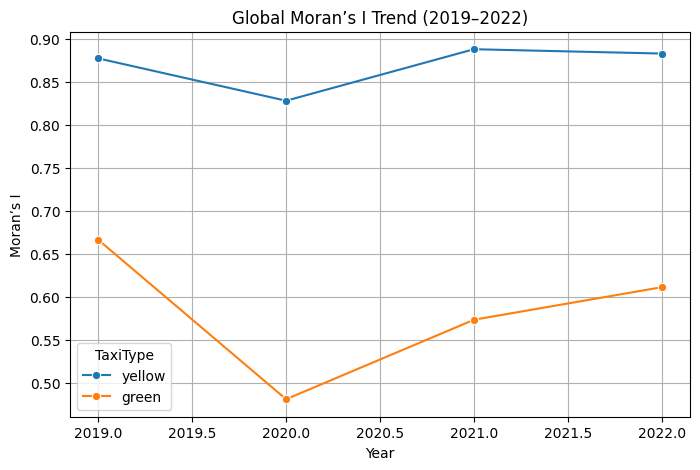

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

sns.lineplot(
    data=moran_results,
    x="Year",
    y="Moran_I",
    hue="TaxiType",
    marker="o"
)

plt.title("Global Moran’s I Trend (2019–2022)")
plt.ylabel("Moran’s I")
plt.xlabel("Year")
plt.grid(True)

plt.savefig(
    f"plot1.png",
    dpi=300,
    bbox_inches="tight"
    )
plt.show()

In [ ]:
!pip install matplotlib-scalebar

## Lisa(Local Moran) Code and Maps

In [ ]:
import matplotlib.pyplot as plt
from libpysal.weights import Queen
from esda.moran import Moran_Local
from matplotlib_scalebar.scalebar import ScaleBar

def professional_lisa_map(geo_df, taxi, year):

    subset = geo_df[
        (geo_df["TaxiType"] == taxi) &
        (geo_df["Year"] == year)
    ].copy()

    subset = subset.dropna(subset=["TripCount_log"])

    w = Queen.from_dataframe(subset)
    w.transform = "r"

    y = subset["TripCount_log"].values
    lisa = Moran_Local(y, w)

    subset["Cluster"] = lisa.q
    subset["p_value"] = lisa.p_sim

    subset["Significant"] = subset["p_value"] < 0.05
    subset.loc[~subset["Significant"], "Cluster"] = 0

    cluster_labels = {
        0: "Not Significant",
        1: "High-High",
        2: "Low-High",
        3: "Low-Low",
        4: "High-Low"
    }

    color_map = {
    0: "#FFFFFF",   # Not Significant - White
    1: "#B2182B",   # High-High - Red
    2: "#EF8A62",   # Low-High - Light Red
    3: "#2166AC",   # Low-Low - Blue
    4: "#67A9CF"    # High-Low - Light Blue
    }

    subset["Color"] = subset["Cluster"].map(color_map)

    fig, ax = plt.subplots(figsize=(12,12))


    from shapely.geometry import Polygon, MultiPolygon


    def remove_interiors(geom):
        if geom.geom_type == "Polygon":
            return Polygon(geom.exterior)
        elif geom.geom_type == "MultiPolygon":
            return MultiPolygon([Polygon(p.exterior) for p in geom.geoms])
        else:
            return geom

    subset["geometry"] = subset["geometry"].apply(remove_interiors)

    subset["geometry"] = subset["geometry"].simplify(5)

    # Plot zones with light grey boundaries
    subset.plot(
        color=subset["Color"],
        edgecolor="black",   # change from black
        linewidth=0.2,
        ax=ax
    )

    # Borough boundaries thicker
    boroughs = zones.dissolve(by="borough")
    boroughs.boundary.plot(ax=ax, color="black", linewidth=1.5)

    import matplotlib.patches as mpatches

    legend_elements = [
        mpatches.Patch(color="#B2182B", label="High-High"),
        mpatches.Patch(color="#EF8A62", label="Low-High"),
        mpatches.Patch(color="#2166AC", label="Low-Low"),
        mpatches.Patch(color="#67A9CF", label="High-Low"),
        mpatches.Patch(color="#FFFFFF", label="Not Significant")
    ]

    ax.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=12)


    # Remove axes
    ax.axis("off")

    ax.set_title(f"LISA Cluster Map - {taxi.capitalize()} {year}",
                 fontsize=18)

    # North Arrow
    ax.annotate("N",
                xy=(0.95, 0.15),
                xytext=(0.95, 0.05),
                arrowprops=dict(facecolor='black', width=3, headwidth=15),
                ha='center',
                fontsize=16,
                xycoords=ax.transAxes)

    # Scale Bar
    scalebar = ScaleBar(1, location='lower left')  # CRS is projected
    ax.add_artist(scalebar)

    plt.savefig(
    f"LISA_{taxi}_{year}.png",
    dpi=300,
    bbox_inches="tight"
    )

    plt.show()

/tmp/ipython-input-2824358602.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


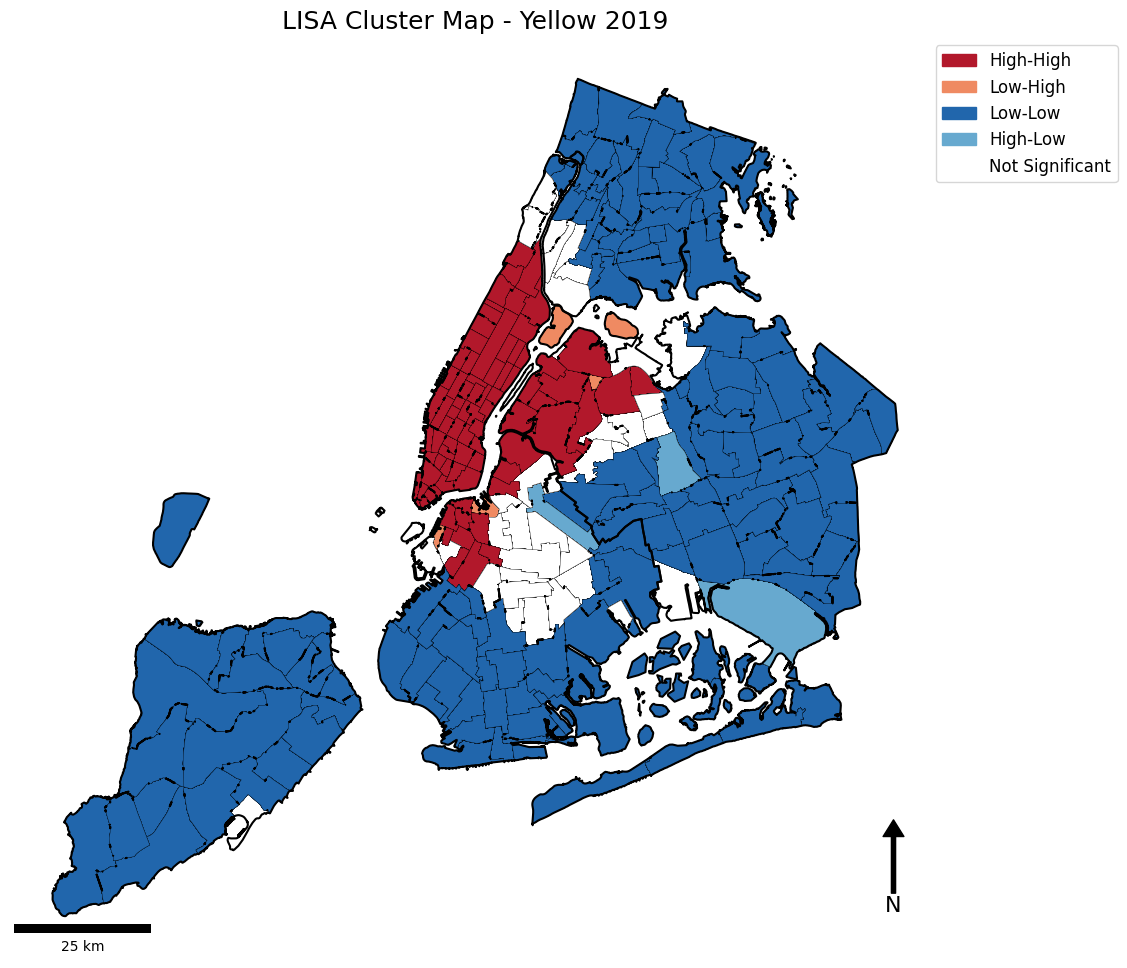

In [ ]:
professional_lisa_map(geo_df, "yellow", 2019)

/tmp/ipython-input-2824358602.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


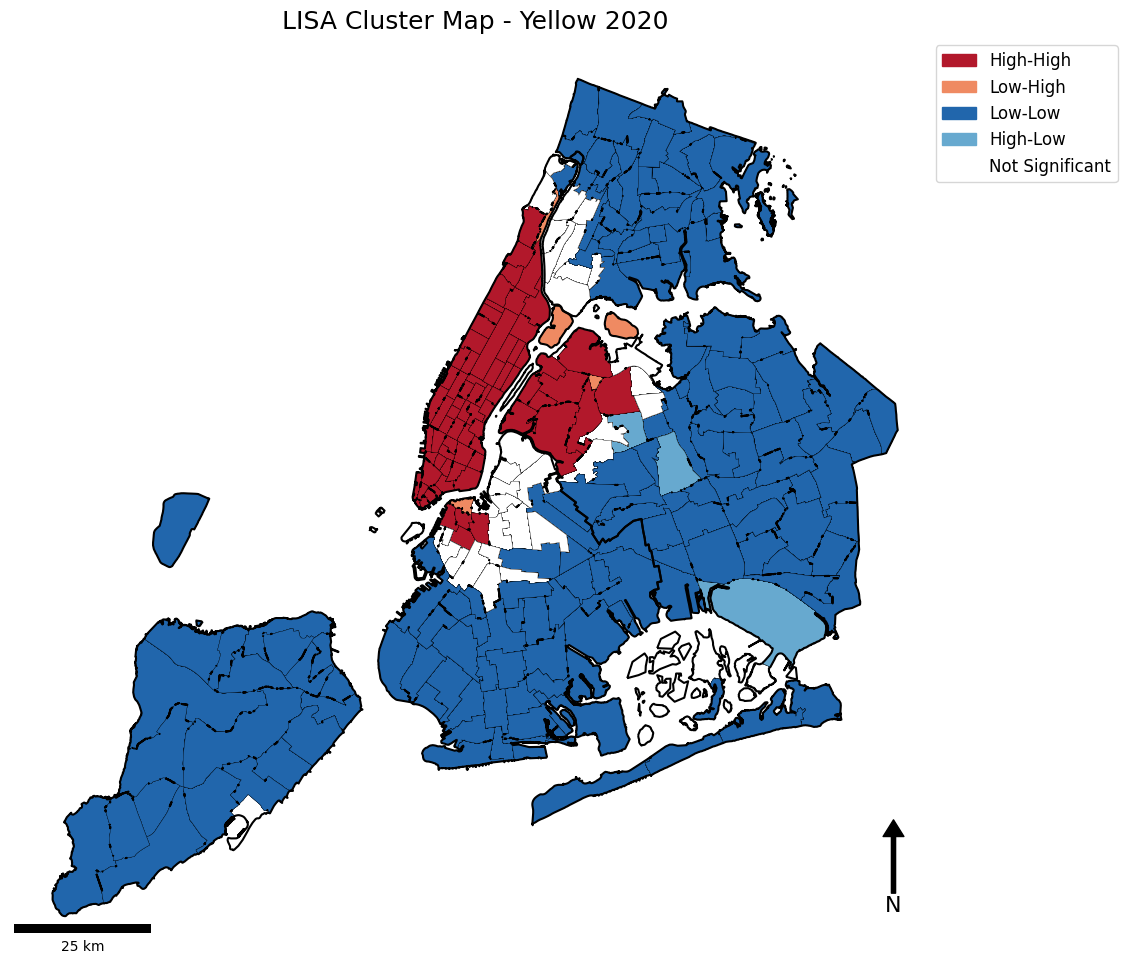

In [ ]:
professional_lisa_map(geo_df, "yellow", 2020)

/tmp/ipython-input-2824358602.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


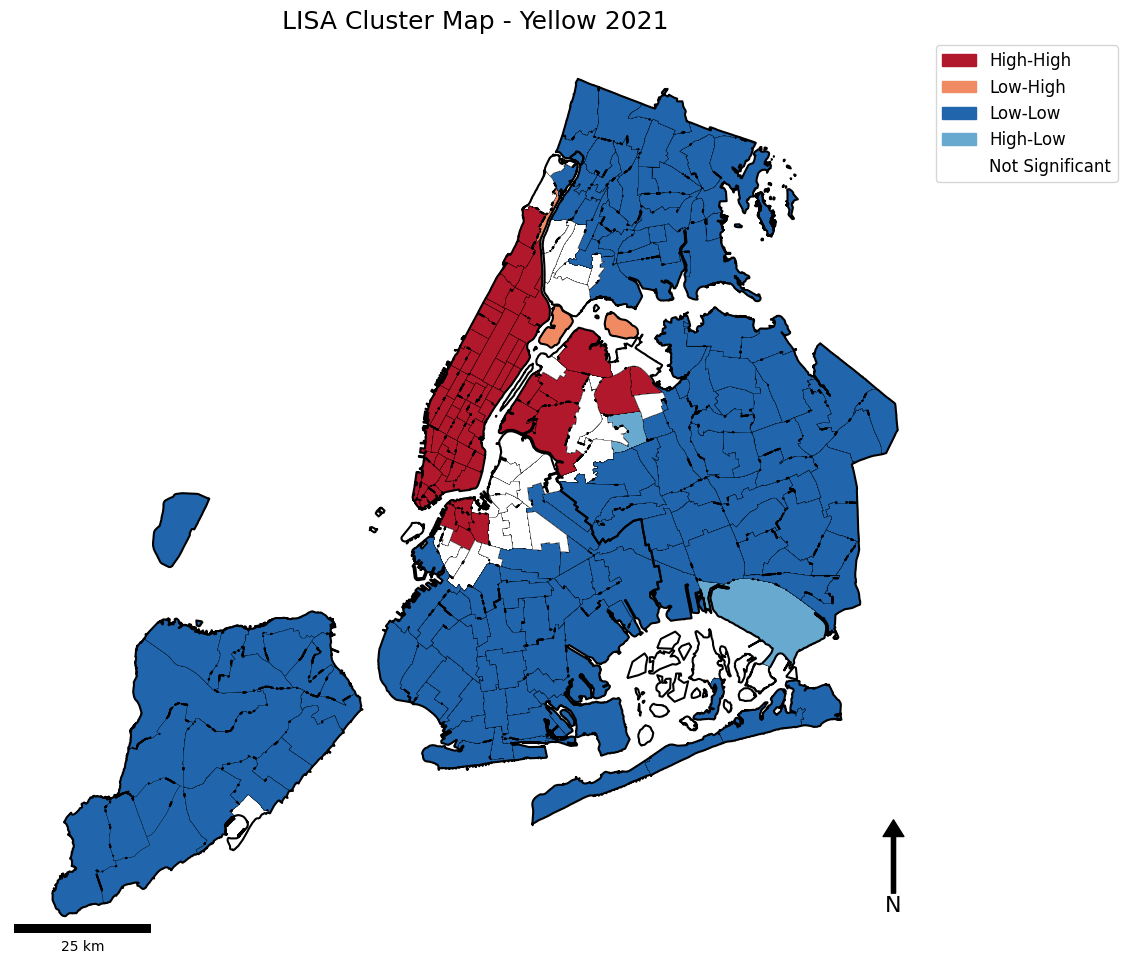

In [ ]:
professional_lisa_map(geo_df, "yellow", 2021)

/tmp/ipython-input-2824358602.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


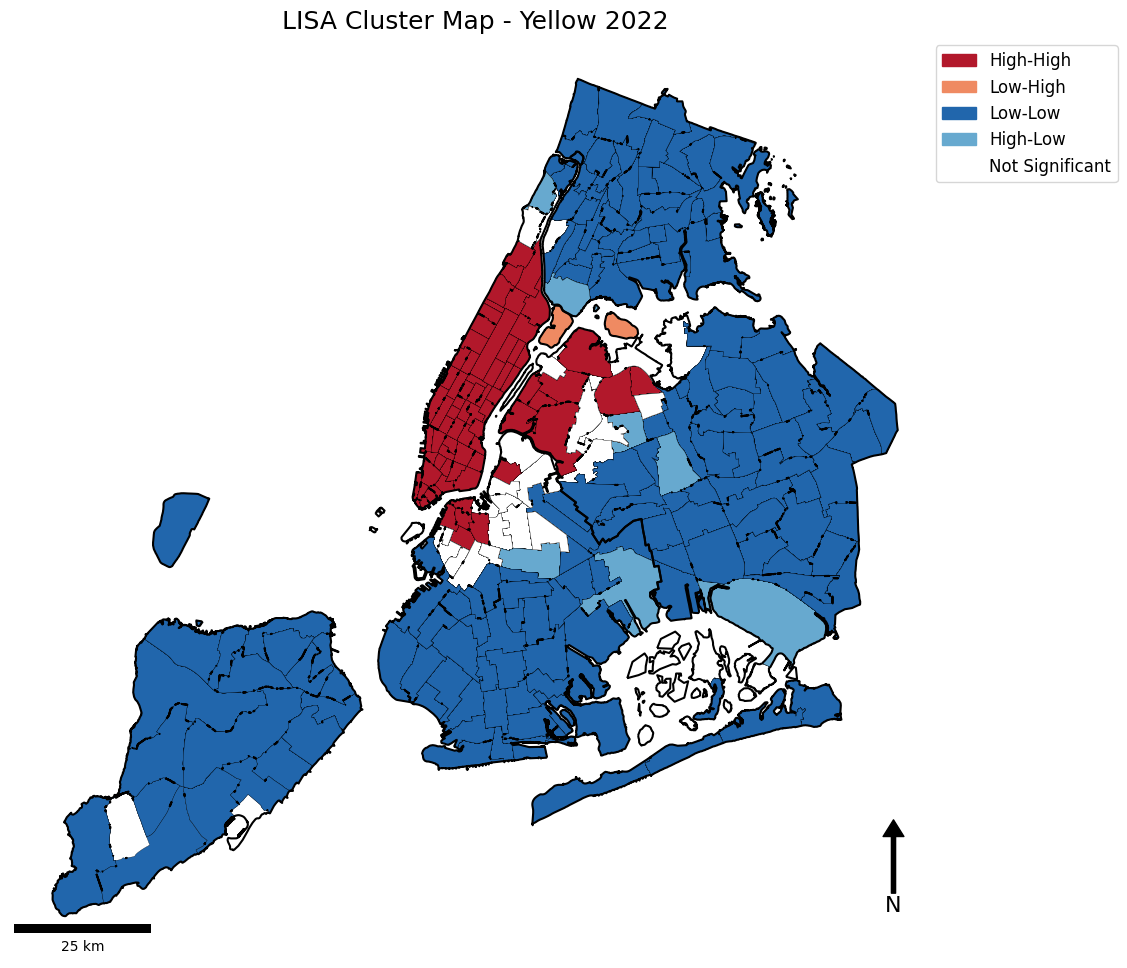

In [ ]:
professional_lisa_map(geo_df, "yellow", 2022)

/tmp/ipython-input-2824358602.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


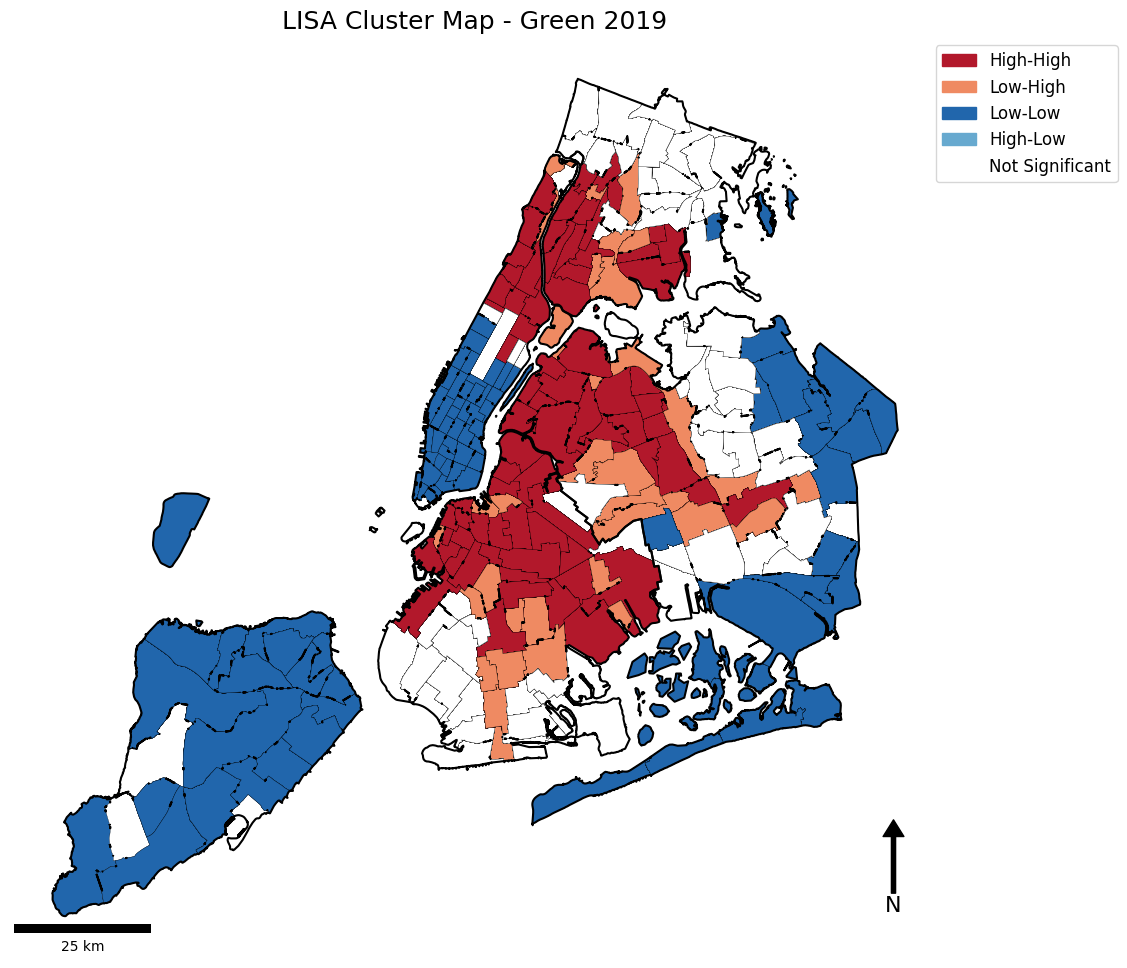

In [ ]:
professional_lisa_map(geo_df, "green", 2019)

/tmp/ipython-input-2824358602.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


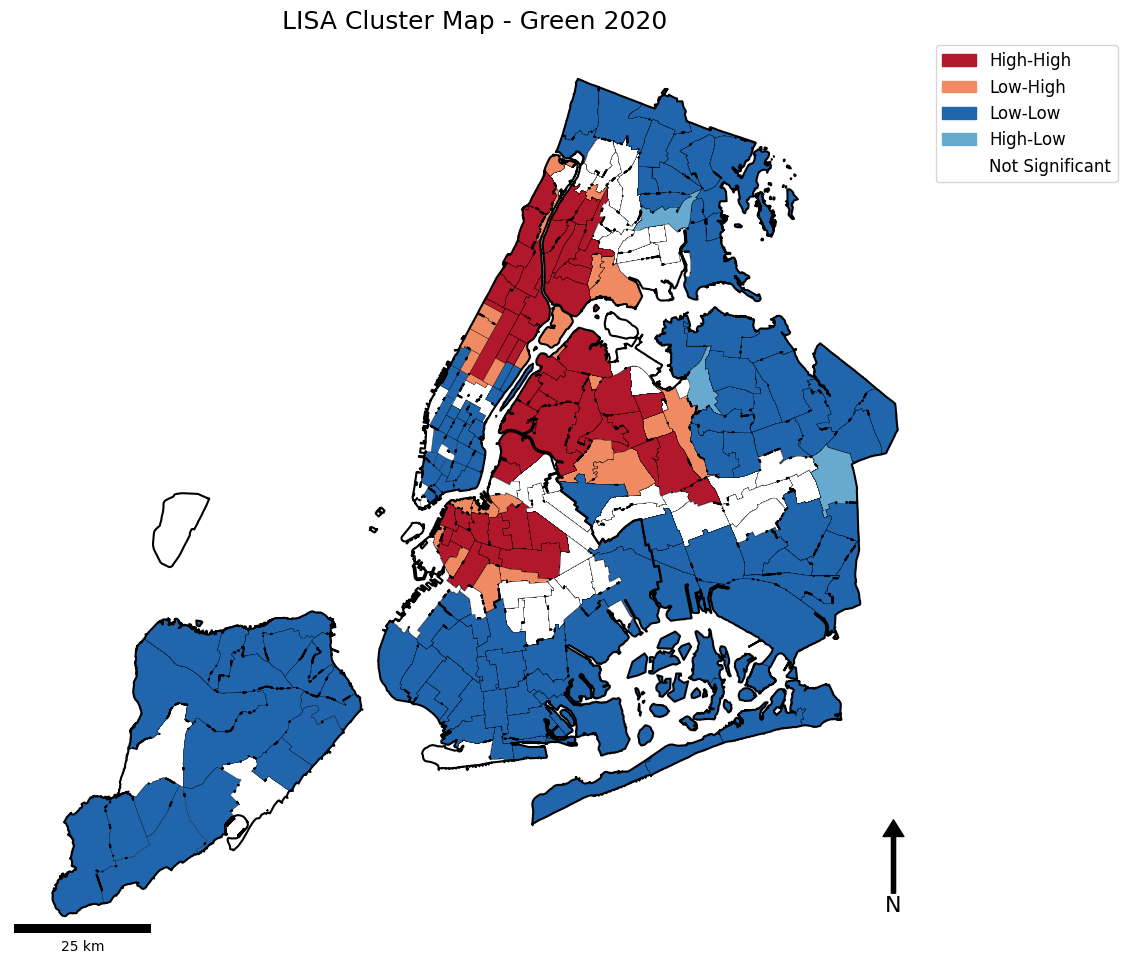

In [ ]:
professional_lisa_map(geo_df, "green", 2020)

/tmp/ipython-input-2824358602.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 2 islands with ids: 1828, 2137.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 1828, ' is an island (no neighbors)')
('WARNING: ', 2137, ' is an island (no neighbors)')


/usr/local/lib/python3.12/dist-packages/esda/moran.py:1354: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


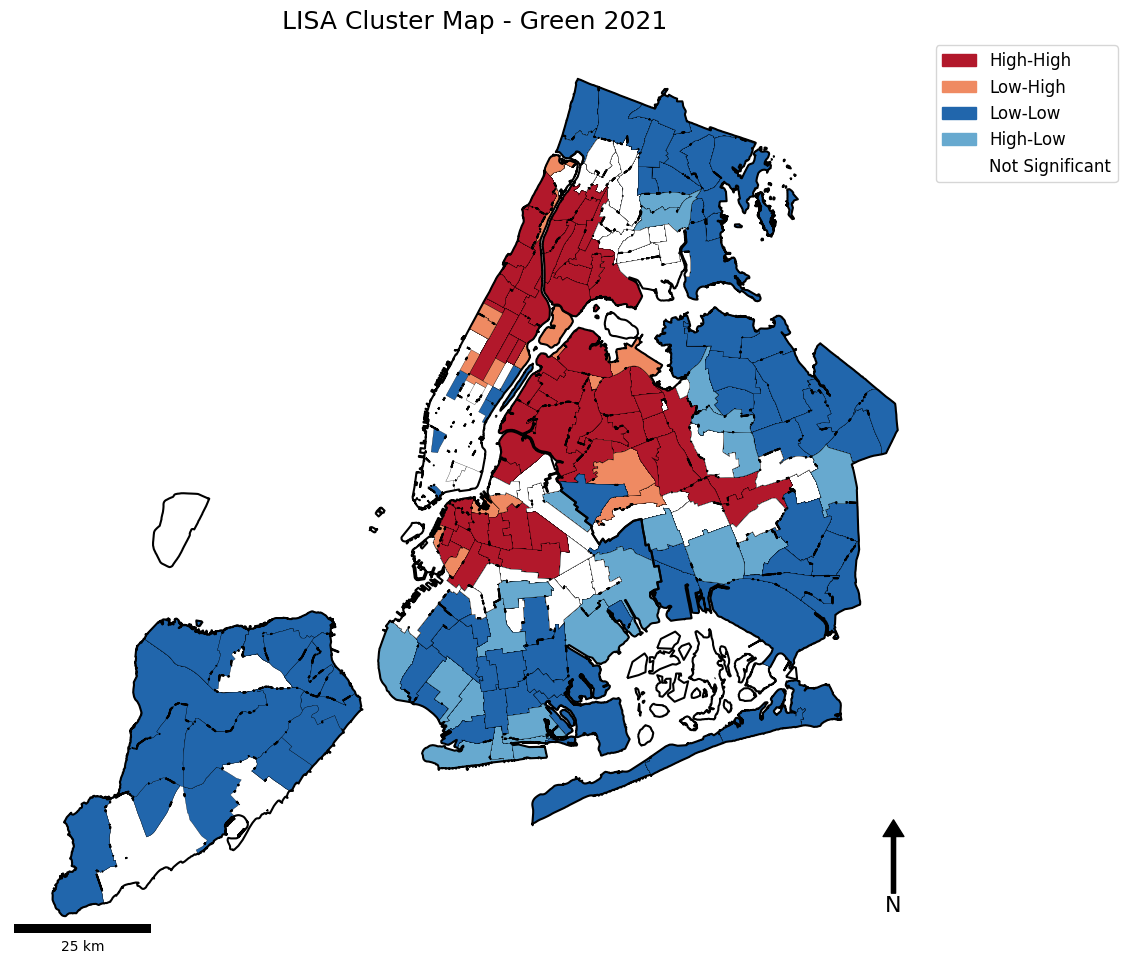

In [ ]:
professional_lisa_map(geo_df, "green", 2021)

/tmp/ipython-input-2824358602.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 2 islands with ids: 14, 379.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 379, ' is an island (no neighbors)')


/usr/local/lib/python3.12/dist-packages/esda/moran.py:1354: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


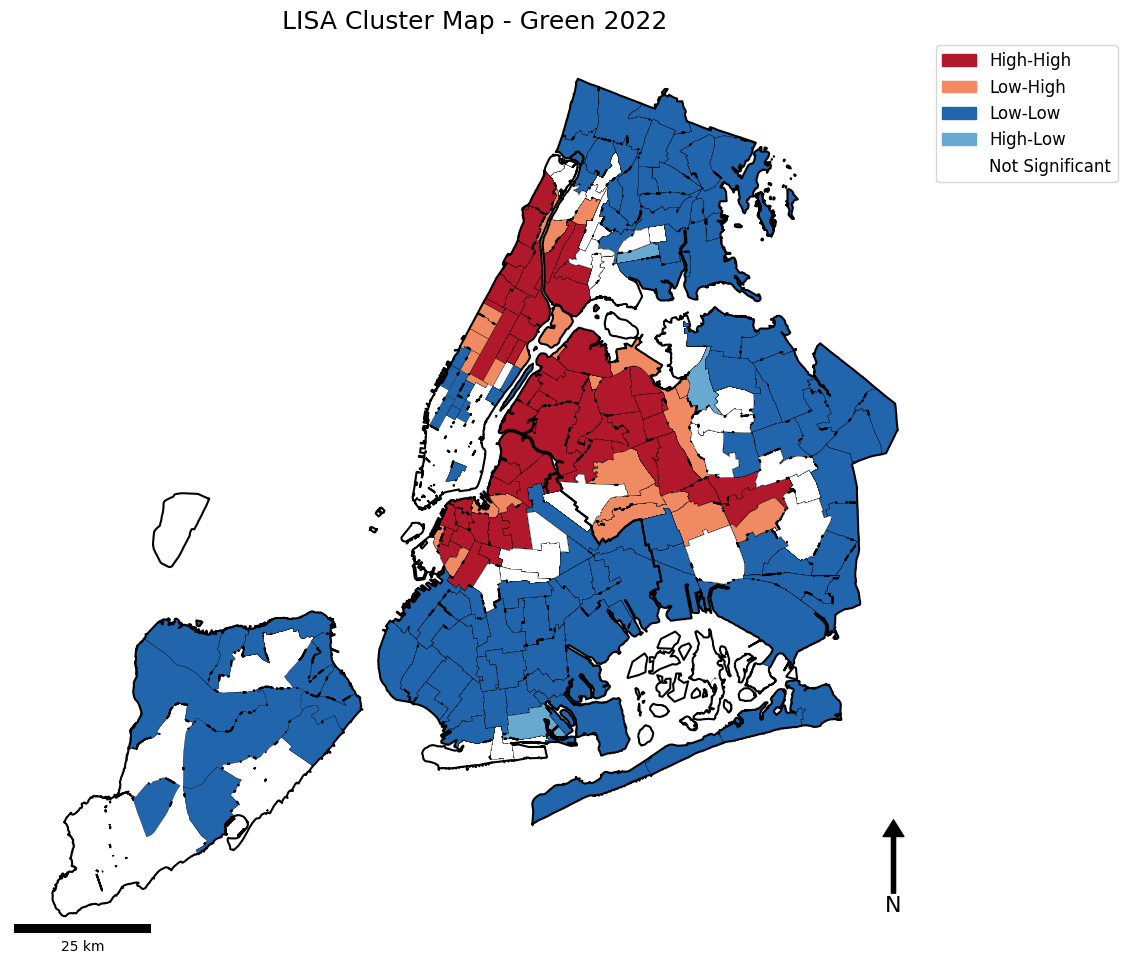

In [ ]:
professional_lisa_map(geo_df, "green", 2022)

# Task2

## Spatial Inequality

In [ ]:
import pandas as pd
import numpy as np

def spatial_variance_analysis(geo_df):

    results = []

    for taxi in ["yellow", "green"]:
        for year in [2019, 2020, 2021, 2022]:

            subset = geo_df[
                (geo_df["TaxiType"] == taxi) &
                (geo_df["Year"] == year)
            ]

            mean_val = subset["TripCount"].mean()
            std_val = subset["TripCount"].std()
            cv = std_val / mean_val

            results.append({
                "TaxiType": taxi,
                "Year": year,
                "Mean": mean_val,
                "StdDev": std_val,
                "CV": cv
            })

    return pd.DataFrame(results)

variance_results = spatial_variance_analysis(geo_df)
variance_results

,TaxiType,Year,Mean,StdDev,CV
0,yellow,2019,22755.671143,54052.866622,2.375358
1,yellow,2020,7183.362478,24971.400308,3.476283
2,yellow,2021,8766.109128,21554.769693,2.458875
3,yellow,2022,11167.560327,26385.005732,2.362647
4,green,2019,1720.323077,4570.912083,2.657008
5,green,2020,460.358300,1937.666947,4.209041
6,green,2021,247.959139,914.483013,3.688039
7,green,2022,295.616401,1137.298660,3.847211


In [ ]:
def borough_analysis(geo_df):

    borough_df = geo_df.groupby(
        ["TaxiType", "Year", "borough"]
    )["TripCount"].sum().reset_index()

    return borough_df

borough_results = borough_analysis(geo_df)
borough_results.head()

,TaxiType,Year,borough,TripCount
0,green,2019,Bronx,236475
1,green,2019,Brooklyn,1213775
2,green,2019,EWR,4
3,green,2019,Manhattan,1757638
4,green,2019,Queens,1376168


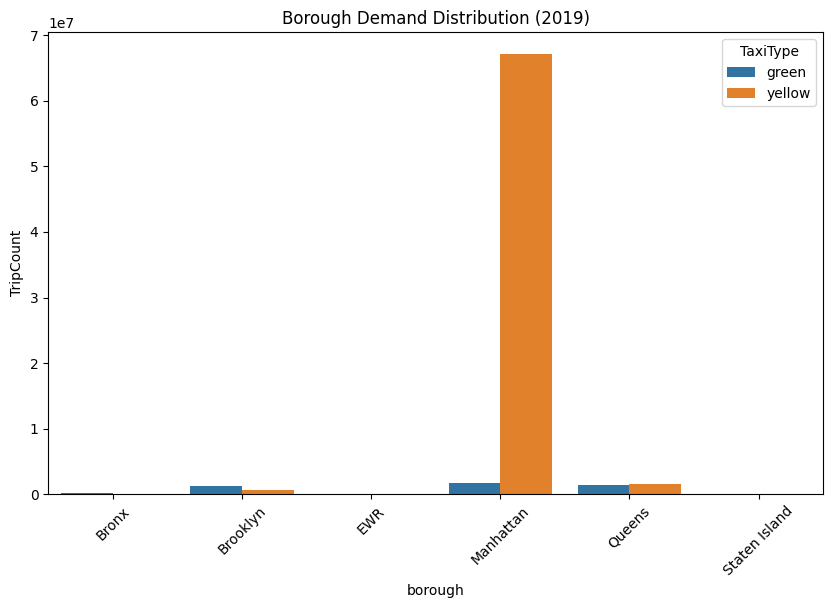

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

sns.barplot(
    data=borough_results[borough_results["Year"]==2019],
    x="borough",
    y="TripCount",
    hue="TaxiType"
)

plt.title("Borough Demand Distribution (2019)")
plt.xticks(rotation=45)
plt.show()

## Spatial Dependence (SAR Model)

In [ ]:
def sar_rho_table(geo_df):

    results = []

    for taxi in ["yellow", "green"]:
        for year in [2019, 2020, 2021, 2022]:

            subset = geo_df[
                (geo_df["TaxiType"] == taxi) &
                (geo_df["Year"] == year)
            ].copy()

            w = Queen.from_dataframe(subset)
            w.transform = "r"

            y = subset["TripCount_log"].values.reshape(-1,1)
            X = np.ones((len(y),1))

            model = ML_Lag(y, X, w=w)

            results.append({
                "TaxiType": taxi,
                "Year": year,
                "Rho": model.rho
            })

    return pd.DataFrame(results)

rho_table = sar_rho_table(geo_df)
rho_table

/tmp/ipython-input-4119369382.py:13: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)
/usr/local/lib/python3.12/dist-packages/spreg/diagnostics_tsls.py:329: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pr = pearsonr(y.flatten(), predy_e.flatten())[0]
/tmp/ipython-input-4119369382.py:13: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: Th

('WARNING: ', 1828, ' is an island (no neighbors)')
('WARNING: ', 2137, ' is an island (no neighbors)')


/tmp/ipython-input-4119369382.py:13: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 2 islands with ids: 14, 379.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 379, ' is an island (no neighbors)')


,TaxiType,Year,Rho
0,yellow,2019,0.977474
1,yellow,2020,0.971058
2,yellow,2021,0.980482
3,yellow,2022,0.978947
4,green,2019,0.957357
5,green,2020,0.920789
6,green,2021,0.942172
7,green,2022,0.942766


## Structural Stability (Pre vs Post Regression)

In [ ]:
import statsmodels.api as sm

def structural_change_regression(geo_df, taxi):

    pre = geo_df[
        (geo_df["TaxiType"] == taxi) &
        (geo_df["Year"] == 2019)
    ]

    post = geo_df[
        (geo_df["TaxiType"] == taxi) &
        (geo_df["Year"] == 2022)
    ]

    merged = pre.merge(
        post[["PULocationID", "TripCount_log"]],
        on="PULocationID",
        suffixes=("_2019", "_2022")
    )

    X = sm.add_constant(merged["TripCount_log_2019"])
    y = merged["TripCount_log_2022"]

    model = sm.OLS(y, X).fit()

    print(f"\nStructural Change Regression - {taxi}")
    print(model.summary())

    return model

reg_yellow = structural_change_regression(geo_df, "yellow")
reg_green = structural_change_regression(geo_df, "green")


Structural Change Regression - yellow
                            OLS Regression Results                            
Dep. Variable:     TripCount_log_2022   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 7.196e+05
Date:                Sun, 15 Feb 2026   Prob (F-statistic):               0.00
Time:                        21:32:12   Log-Likelihood:                -36508.
No. Observations:               35321   AIC:                         7.302e+04
Df Residuals:                   35319   BIC:                         7.304e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [20]:
#TASK 4

# Imports + Load Data
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from spreg import ML_Lag, OLS, ML_Error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from libpysal.weights import Queen
from esda.getisord import G_Local

zones = gpd.read_file("taxi_zones.shp")
trip_data = pd.read_csv("common_tripcount_2019_2022.csv")

geo_df = zones.merge(trip_data, left_on="LocationID", right_on="PULocationID")

subset = geo_df[(geo_df["TaxiType"]=="yellow") & (geo_df["Year"]==2019)].dropna()

subset.head()


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,TripCount,AvgFare,AvgTotalAmount,AvgDistance,AvgPassengers,AvgTip,AvgCongestionSurcharge,Year,Month,TaxiType,TripCount_log
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1,7,10.714286,27.675714,14.957143,1.000000,3.338571,0.00000,2019,1,yellow,2.079442
1,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1,16,7.656875,13.538750,3.780000,1.125000,4.081875,0.15625,2019,2,yellow,2.833213
2,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1,17,8.531176,14.461176,7.300588,1.235294,0.865294,0.00000,2019,3,yellow,2.890372
3,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1,25,7.941200,22.524800,5.978400,1.040000,12.763600,0.40000,2019,4,yellow,3.258097
4,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1,20,6.325500,26.804500,5.307500,1.250000,15.454000,0.00000,2019,5,yellow,3.044522


In [21]:
#GWR (Spatial Non-Stationarity)

coords = np.column_stack([
    subset.geometry.centroid.x,
    subset.geometry.centroid.y
])

y = subset["TripCount_log"].values.reshape(-1,1)
X = subset[["AvgDistance","AvgFare"]].values

bw = Sel_BW(coords, y, X).search()

gwr_model = GWR(coords, y, X, bw).fit()

print(gwr_model.summary())
print("Global R2:", gwr_model.R2)
print("Mean Local R2:", gwr_model.localR2.mean())


Model type                                                         Gaussian
Number of observations:                                                3053
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          26961.733
Log-likelihood:                                                   -7657.185
AIC:                                                              15320.370
AICc:                                                             15322.383
BIC:                                                               2488.899
R2:                                                                   0.135
Adj. R2:                                                              0.134

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

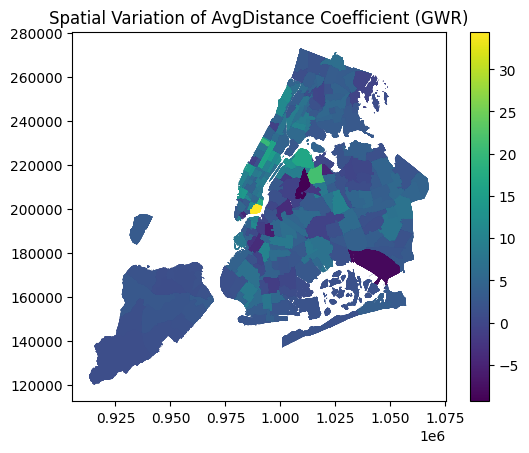

In [22]:
#GWR Coefficient Map
subset["coef_distance"] = gwr_model.params[:,0]

subset.plot(column="coef_distance", legend=True)
plt.title("Spatial Variation of AvgDistance Coefficient (GWR)")
plt.show()


In [23]:
#Train/Test Split + Spatial Weights
features = ["AvgDistance","AvgFare","AvgPassengers"]

X = subset[features].values
y = subset["TripCount_log"].values.reshape(-1,1)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, subset.index, test_size=0.2, random_state=42
)

train_df = subset.loc[idx_train]

w = Queen.from_dataframe(train_df)
w.transform = "r"


C:\Users\divya\AppData\Local\Temp\ipykernel_15064\2603504584.py:13: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(train_df)
C:\Users\divya\AppData\Roaming\Python\Python313\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


In [30]:
# SAR Model

sar = ML_Lag(y_train, X_train, w=w)

beta_sar = sar.betas.flatten()

# Remove rho (last element)
beta_sar_reg = beta_sar[:-1]

y_pred_sar = X_test @ beta_sar_reg[1:] + beta_sar_reg[0]

rmse_sar = np.sqrt(mean_squared_error(y_test, y_pred_sar))

print("SAR RMSE:", rmse_sar)


SAR RMSE: 6.931059089004406


In [18]:
#OLS Baseline
ols = OLS(y_train, X_train)
beta = ols.betas

y_pred_ols = X_test @ beta[1:] + beta[0]
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))

print("OLS RMSE:", rmse_ols)


OLS RMSE: 3.08278859117713


In [27]:
# Spatial Error Model (SEM)

sem = ML_Error(y_train, X_train, w=w)

beta_sem = sem.betas.flatten()

# Ignore last coefficient (lambda)
beta_sem_reg = beta_sem[:-1]

y_pred_sem = X_test @ beta_sem_reg[1:] + beta_sem_reg[0]

rmse_sem = np.sqrt(mean_squared_error(y_test, y_pred_sem))

print("SEM RMSE:", rmse_sem)


C:\Users\divya\AppData\Roaming\Python\Python313\site-packages\spreg\ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


SEM RMSE: 4.671125353975495


In [31]:
#RMSE Comparison
print("OLS RMSE:", rmse_ols)
print("SAR RMSE:", rmse_sar)
print("SEM RMSE:", rmse_sem)


OLS RMSE: 3.08278859117713
SAR RMSE: 6.931059089004406
SEM RMSE: 4.671125353975495


C:\Users\divya\AppData\Local\Temp\ipykernel_15064\1589816361.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_full = Queen.from_dataframe(subset)
C:\Users\divya\AppData\Roaming\Python\Python313\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


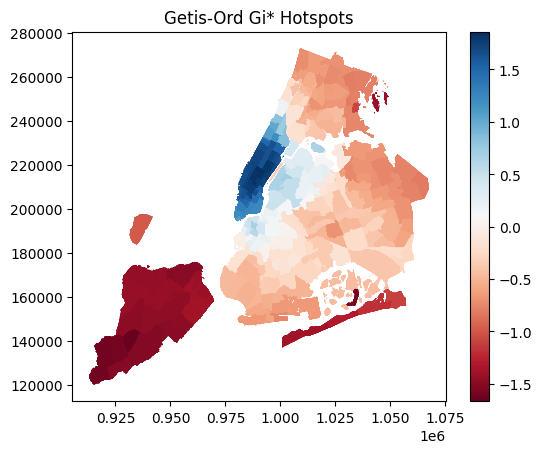

In [32]:
#Getis–Ord Gi* Hotspots
w_full = Queen.from_dataframe(subset)
w_full.transform="r"

g = G_Local(subset["TripCount_log"], w_full)

subset["GiZ"] = g.Zs

subset.plot(column="GiZ", cmap="RdBu", legend=True)
plt.title("Getis-Ord Gi* Hotspots")
plt.show()

